# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [3]:
# using SQLite Table to read data.
#con = sqlite3.connect('database.sqlite') 
con = sqlite3.connect('C://Users//40001002//Downloads//amazon-fine-food-reviews//database.sqlite')

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
print("*****",type(actualScore))
print(actualScore)
positiveNegative = actualScore.map(partition) 

filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

***** <class 'pandas.core.series.Series'>
0       5
1       1
2       4
3       2
4       5
5       4
6       5
7       5
8       5
9       5
10      5
11      5
12      1
13      4
14      5
15      5
16      2
17      5
18      5
19      5
20      5
21      5
22      5
23      5
24      5
25      5
26      1
27      4
28      5
29      5
       ..
4970    2
4971    2
4972    1
4973    1
4974    4
4975    5
4976    4
4977    5
4978    5
4979    4
4980    5
4981    2
4982    5
4983    4
4984    4
4985    5
4986    5
4987    4
4988    5
4989    5
4990    5
4991    5
4992    5
4993    4
4994    2
4995    2
4996    4
4997    5
4998    2
4999    1
Name: Score, Length: 5000, dtype: int64
Number of data points in our data (5000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [4]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [6]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [7]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [9]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(4986, 10)

In [11]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.72

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [13]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(4986, 10)


1    4178
0     808
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no 

In [16]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [23]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Why is this $[...] when the same product is available for $[...] here? />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow So far two two star reviews One obviously had no idea what they were ordering the other wants crispy cookies Hey I am sorry but these reviews 

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I am sorry; but these reviews do nobody any good beyond reminding us to look  before ordering.<br /><br />These are chocolate-oatmeal cookies.  If you do not like that combination, do not order this type of cookie.  I find the combo quite nice, really.  The oatmeal sort of "calms" the rich chocolate flavor and gives the cookie sort of a coconut-type consistency.  Now let is also remember that tastes differ; so, I have given my opinion.<br /><br />Then, these are soft, chewy cookies -- as advertised.  They are not "crispy" cookies, or the blurb would say "crispy," rather than "chewy."  I happen to like raw cookie dough; however, I do not see where these taste like raw cookie dough.  Both are soft, however, so is this the confusion?  And, yes, they stick together.  Soft cookies tend to do that.  They are not individually wrapped, which would add to the cost.  Oh y

In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Wow So far two two star reviews One obviously had no idea what they were ordering the other wants crispy cookies Hey I am sorry but these reviews do nobody any good beyond reminding us to look before ordering br br These are chocolate oatmeal cookies If you do not like that combination do not order this type of cookie I find the combo quite nice really The oatmeal sort of calms the rich chocolate flavor and gives the cookie sort of a coconut type consistency Now let is also remember that tastes differ so I have given my opinion br br Then these are soft chewy cookies as advertised They are not crispy cookies or the blurb would say crispy rather than chewy I happen to like raw cookie dough however I do not see where these taste like raw cookie dough Both are soft however so is this the confusion And yes they stick together Soft cookies tend to do that They are not individually wrapped which would add to the cost Oh yeah chocolate chip cookies tend to be somewhat sweet br br So if you wa

In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [24]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    #sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 4986/4986 [00:02<00:00, 2317.31it/s]


In [25]:
preprocessed_reviews[1500]

'Wow So far two two star reviews One obviously had no idea what they were ordering the other wants crispy cookies Hey I am sorry but these reviews do nobody any good beyond reminding us to look before ordering These are chocolate oatmeal cookies If you do not like that combination do not order this type of cookie I find the combo quite nice really The oatmeal sort of calms the rich chocolate flavor and gives the cookie sort of a coconut type consistency Now let is also remember that tastes differ so I have given my opinion Then these are soft chewy cookies as advertised They are not crispy cookies or the blurb would say crispy rather than chewy I happen to like raw cookie dough however I do not see where these taste like raw cookie dough Both are soft however so is this the confusion And yes they stick together Soft cookies tend to do that They are not individually wrapped which would add to the cost Oh yeah chocolate chip cookies tend to be somewhat sweet So if you want something hard

# [4] Featurization

## [4.1] BAG OF WORDS

In [75]:
#BoW

#print(preprocessed_reviews)
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)

print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])
X = final_counts.toarray()
print("some feature names ", count_vect.get_feature_names()[733])
print(type(X))
Y = X[0][733]
print('test', Y)
print(Y.size)
print(X[4])
print(X.size)
print(final_counts)


Z = final_counts.todense()
print(Z.size)
if (str(X[0]) == str(Z[0])):
    print("matrix are equal")
else:
    print("not equal")

some feature names  ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 12997)
the number of unique words  12997
some feature names  available
<class 'numpy.ndarray'>
test 1
1
[0 0 0 ... 0 0 0]
64803042
  (0, 733)	1
  (0, 2604)	1
  (0, 4460)	1
  (0, 4766)	1
  (0, 7479)	1
  (0, 8733)	1
  (0, 8815)	1
  (0, 9617)	1
  (0, 10946)	1
  (0, 11819)	1
  (0, 11889)	1
  (0, 12185)	1
  (0, 12403)	1
  (1, 810)	1
  (1, 937)	1
  (1, 1521)	1
  (1, 4460)	1
  (1, 5013)	1
  (1, 7610)	1
  (1, 8815)	1
  (1, 10034)	1
  (1, 12265)	1
  (1, 12403)	1
  (2, 944)	1
  (2, 1567)	1
  :	:
  (4985, 1244)	1
  (4985, 1508)	1
  (4985, 1626)	1
  (4985, 2166)	1
  (4985, 3503)	1
  (4985, 4900)	1
  (4985, 6520)	1
  (4985, 6693)	1
  (4985, 6924)	1
  (4985, 7610)	4
  (4985, 7788)	1
  (4985, 8693)	1
  (4985, 9076)	1
  (4985, 10239)	1
  (4985, 10370)	1
  (4985, 10462)	1
 

## [4.2] Bi-Grams and n-Grams.

In [177]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice


# skipping stop word removal process
from tqdm import tqdm
preprocessed_reviews_for_BN_Grams = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    preprocessed_reviews_for_BN_Grams.append(sentance.strip())

print(type(preprocessed_reviews_for_BN_Grams))
    
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews_for_BN_Grams)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

Z = final_bigram_counts.toarray()
print(final_bigram_counts)
print(type(final_bigram_counts))
print(Z)

100%|██████████| 4986/4986 [00:02<00:00, 2234.83it/s]


<class 'list'>
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 5000)
the number of unique words including both unigrams and bigrams  5000
  (0, 2823)	1
  (0, 2018)	1
  (0, 3241)	1
  (0, 4126)	1
  (0, 4788)	1
  (0, 2095)	1
  (0, 2663)	1
  (0, 3388)	1
  (0, 2942)	1
  (0, 657)	1
  (0, 3205)	1
  (0, 4475)	1
  (0, 1000)	1
  (0, 2814)	1
  (0, 304)	1
  (0, 152)	1
  (0, 1837)	1
  (0, 1439)	1
  (0, 403)	1
  (0, 3232)	1
  (0, 3423)	1
  (0, 3962)	2
  (0, 4777)	1
  (0, 4274)	1
  (0, 2006)	2
  :	:
  (4985, 680)	1
  (4985, 703)	1
  (4985, 2186)	1
  (4985, 2175)	1
  (4985, 3862)	1
  (4985, 888)	1
  (4985, 4603)	1
  (4985, 71)	1
  (4985, 4582)	1
  (4985, 1610)	1
  (4985, 4656)	1
  (4985, 115)	1
  (4985, 2894)	1
  (4985, 3609)	1
  (4985, 4372)	2
  (4985, 2611)	1
  (4985, 2109)	4
  (4985, 2713)	4
  (4985, 4575)	1
  (4985, 657)	1
  (4985, 2814)	1
  (4985, 152)	3
  (4985, 3962)	2
  (4985, 4274)	1
  (4985, 2006)	1
<class 'scipy.sparse.csr.csr

## [4.3] TF-IDF

In [107]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews_for_BN_Grams)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])


some sample features(unique words in the corpus) ['ability', 'able', 'able to', 'about', 'about half', 'about how', 'about it', 'about minutes', 'about months', 'about my']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 6632)
the number of unique words including both unigrams and bigrams  6632


## [4.4] Word2Vec

In [108]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews_for_BN_Grams:
    list_of_sentance.append(sentance.split())

In [109]:
# Using Google News Word2Vectors


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('good', 0.8638573884963989), ('wonderful', 0.8560205101966858), ('nice', 0.8478937745094299), ('light', 0.8271522521972656), ('delicious', 0.8247737884521484), ('also', 0.8198601007461548), ('deal', 0.8170545101165771), ('very', 0.8141973614692688), ('tasty', 0.8124412894248962), ('pretty', 0.8020340204238892)]
[('mixes', 0.9674810767173767), ('thus', 0.9653469920158386), ('Kona', 0.9639554023742676), ('doubt', 0.9637885093688965), ('cocoas', 0.9617862701416016), ('teas', 0.9598392248153687), ('lingering', 0.9564831256866455), ('root', 0.9560176730155945), ('jerky', 0.9556533694267273), ('highest', 0.9555777907371521)]


In [110]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  4530
sample words  ['Why', 'is', 'this', 'when', 'the', 'same', 'product', 'available', 'for', 'here', 'The', 'and', 'are', 'of', 'course', 'total', 'Pretty', 'stinky', 'but', 'only', 'right', 'nearby', 'We', 'have', 'used', 'Ca', 'not', 'beat', 'it', 'Great', 'I', 'just', 'received', 'my', 'shipment', 'could', 'hardly', 'wait', 'to', 'try', 'love', 'which', 'what', 'we', 'call', 'them', 'instead', 'because', 'they', 'can']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [111]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 4986/4986 [00:06<00:00, 734.12it/s]


4986
50


#### [4.4.1.2] TFIDF weighted W2v

In [112]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()

tf_idf_matrix = model.fit_transform(preprocessed_reviews_for_BN_Grams)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))


In [113]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
    
    

100%|██████████| 4986/4986 [00:49<00:00, 101.35it/s]


## [5.1] Applying KNN brute force

### [5.1.1] Applying KNN brute force on BOW,<font color='red'> SET 1</font>

In [46]:
# reference: https://www.kaggle.com/premvardhan/amazon-fine-food-reviews-analysis-using-knn


def k_classifier_brute(X_train, y_train):
    # creating odd list of K for KNN
    myList = list(range(0,50))
    neighbors = list(filter(lambda x: x % 2 != 0, myList))

    # empty list that will hold cv scores
    cv_scores = []

    # perform 10-fold cross validation
    for k in neighbors:
        knn = KNeighborsClassifier(n_neighbors=k, algorithm = "brute")
        scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
        cv_scores.append(scores.mean())

    # changing to misclassification error
    MSE = [1 - x for x in cv_scores]

    # determining best k
    optimal_k = neighbors[MSE.index(min(MSE))]
    print('\nThe optimal number of neighbors is %d.' % optimal_k)

    # plot misclassification error vs k 
    plt.plot(neighbors, MSE)

    for xy in zip(neighbors, np.round(MSE,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
    plt.title("Misclassification Error vs K")
    plt.xlabel('Number of Neighbors K')
    plt.ylabel('Misclassification Error')
    plt.show()

    print("the misclassification error for each k value is : ", np.round(MSE,3))
    return optimal_k


1    4178
0     808
Name: Score, dtype: int64
(1400,) (1400,) (600,) (600,)

The optimal number of neighbors is 3.


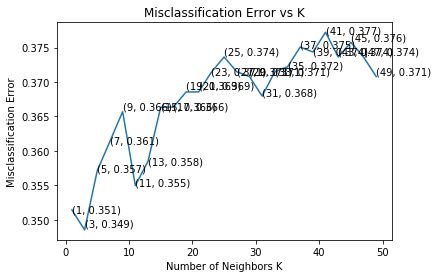

the misclassification error for each k value is :  [0.351 0.349 0.357 0.361 0.366 0.355 0.358 0.366 0.366 0.369 0.369 0.371
 0.374 0.371 0.371 0.368 0.371 0.372 0.375 0.374 0.377 0.374 0.376 0.374
 0.371]
Train accuracy 0.8
Train Error 0.200000%

The accuracy of the knn classifier for k = 3 is 61.500000%


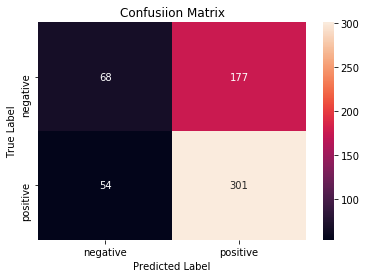

In [47]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
#from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection
#from sklearn import model_selection


# taking the amazon reviwe data set 1200 +ve and 800 -ve.
print(final.Score.value_counts())
Data_POS = final[final["Score"] == 1].sample(n = 1200)
Data_NEG = final[final["Score"] == 0].sample(n = 800)

#sort the data w.r.t time stamp
final_data = pd.concat([Data_POS , Data_NEG])
final_data = final_data.sort_values(by = 'Time')

# taking out text and score and sending it to train, test split
final_Review_Text = final_data['Text']
final_Review_Label = final_data['Score']

from sklearn.model_selection import train_test_split
X_train, x_test, y_train, y_test = train_test_split(final_Review_Text, final_Review_Label, test_size = 0.3, random_state = 42)
print(X_train.shape, y_train.shape, x_test.shape, y_test.shape)

#converting text to vector
bow = CountVectorizer()
X_train = bow.fit_transform(X_train)
x_test = bow.transform(x_test)



optimal_k_bow = k_classifier_brute(X_train, y_train)
optimal_k_bow

knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k_bow)

# fitting the model
knn_optimal.fit(X_train, y_train)
#knn_optimal.fit(bow_data, y_train)

# predict the response
pred = knn_optimal.predict(x_test)

# Accuracy on train data
train_acc_bow = knn_optimal.score(X_train, y_train)
print("Train accuracy", train_acc_bow)

# Error on train data
train_err_bow = 1-train_acc_bow
print("Train Error %f%%" % (train_err_bow))

# evaluate accuracy on test data
acc_bow = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k_bow, acc_bow))

# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### [5.1.2] Applying KNN brute force on TFIDF,<font color='red'> SET 2</font>

1    4178
0     808
Name: Score, dtype: int64
(1400,) (1400,) (600,) (600,)

The optimal number of neighbors is 49.


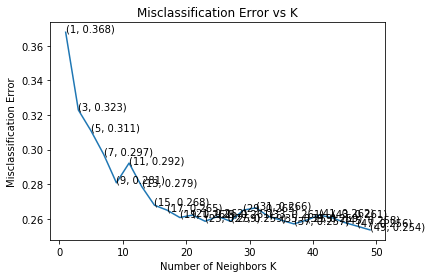

the misclassification error for each k value is :  [0.368 0.323 0.311 0.297 0.281 0.292 0.279 0.268 0.265 0.261 0.262 0.259
 0.261 0.259 0.265 0.266 0.261 0.259 0.257 0.259 0.262 0.261 0.258 0.256
 0.254]
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
<class 'numpy.ndarray'>
1400
[0. 0. 0. ... 0. 0. 0.]
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
<class 'pandas.core.series.Series'>
1400
4420    1
2401    0
2102    0
3222    1
3211    0
2352    0
4677    0
3316    1
226     0
2121    1
977     0
4426    1
2036    0
2742    1
1094    1
4314    0
1025    0
2069    0
2550    0
3374    0
718     1
3225    1
1372    1
4565    1
4572    0
1312    0
3861    1
4625    0
3703    1
3419    0
       ..
622     0
50      1
3536    1
4396    1
1818    0
1665    0
3690    0
3936    1
3781    0
1664    0
2692    0
208     1
3375    0
3251    0
3062    0
3692    0
1990    0
3674    1
2051    0
2012    1
1104    0
4437    1
3757    0
12      0
1683    1
2011    0
3231    1
3679    1
1698    1
3291    1

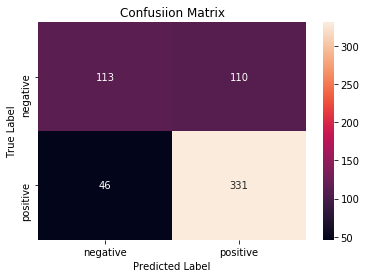

In [161]:
#KNN for TF-IDF

# taking the amazon reviwe data set 1200 +ve and 800 -ve.
print(final.Score.value_counts())
Data_POS = final[final["Score"] == 1].sample(n = 1200)
Data_NEG = final[final["Score"] == 0].sample(n = 800)

#sort the data w.r.t time stamp
final_data = pd.concat([Data_POS , Data_NEG])
final_data = final_data.sort_values(by = 'Time')

# taking out text and score and sending it to train, test split
final_Review_Text = final_data['Text']
final_Review_Label = final_data['Score']

from sklearn.model_selection import train_test_split
X_train, x_test, y_train, y_test = train_test_split(final_Review_Text, final_Review_Label, test_size = 0.3, random_state = 42)
print(X_train.shape, y_train.shape, x_test.shape, y_test.shape)


tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
#tf_idf_vect.fit(X_train)

#print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

X_train = tf_idf_vect.fit_transform(X_train)
X_train = X_train.toarray()
x_test = tf_idf_vect.transform(x_test)
x_test = x_test.toarray()

optimal_k_tfidf = k_classifier_brute(X_train, y_train)
optimal_k_tfidf

knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k_tfidf)

# fitting the model     
knn_optimal.fit(X_train, y_train)


# predict the response
pred = knn_optimal.predict(x_test)

# Accuracy on train data
train_acc_tfidf = knn_optimal.score(X_train, y_train)
print("Train accuracy", train_acc_tfidf)

# Error on train data
train_err_tfidf = 1-train_acc_tfidf
print("Train Error %f%%" % (train_err_tfidf))

# evaluate accuracy on test data
acc_tfidf = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k_tfidf, acc_tfidf))

# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()




### [5.1.3] Applying KNN brute force on AVG W2V,<font color='red'> SET 3</font>

In [30]:
# taking the amazon reviwe data set 1200 +ve and 800 -ve.
print(final.Score.value_counts())
Data_POS = final[final["Score"] == 1].sample(n = 1200)
Data_NEG = final[final["Score"] == 0].sample(n = 800)

#sort the data w.r.t time stamp
final_data = pd.concat([Data_POS , Data_NEG])
final_data = final_data.sort_values(by = 'Time')

# taking out text and score and sending it to train, test split
final_Review_Text = final_data['Text']
final_Review_Label = final_data['Score']

from sklearn.model_selection import train_test_split

X_train, x_test, y_train, y_test = train_test_split(final_Review_Text, final_Review_Label, test_size = 0.3, random_state = 42)
print(X_train.shape, y_train.shape, x_test.shape, y_test.shape)

print(type(X_train))
print(X_train.shape)
#print(X_train)
X_train = X_train.tolist()
x_test = x_test.tolist()
Data_For_AVG_W2V = X_train + x_test

1    4178
0     808
Name: Score, dtype: int64
(1400,) (1400,) (600,) (600,)
<class 'pandas.core.series.Series'>
(1400,)


In [31]:
i=0
list_of_sentance=[]

for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())


is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")


[('good', 0.8944063186645508), ('perfect', 0.8605881929397583), ('nice', 0.8525068759918213), ('delicious', 0.8474948406219482), ('amazing', 0.8408904671669006), ('wonderful', 0.833315372467041), ('deal', 0.8162684440612793), ('soothing', 0.805113673210144), ('presentation', 0.8044476509094238), ('pretty', 0.8040435314178467)]
[('popcorn', 0.9674608111381531), ('mixes', 0.9673116207122803), ('negative', 0.966584324836731), ('doubt', 0.966347336769104), ('kinds', 0.96305912733078), ('image', 0.9625533223152161), ('Wrigley', 0.9610104560852051), ('jerky', 0.960940420627594), ('thus', 0.9600762128829956), ('barbecue', 0.9592084288597107)]


In [32]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(X_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

X_train = sent_vectors
#----------------------------------------------------
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(x_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

x_test = sent_vectors
#------------------------------------------------------
print(type(X_train))
print(len(X_train))

number of words that occured minimum 5 times  4530
sample words  ['Why', 'is', 'this', 'when', 'the', 'same', 'product', 'available', 'for', 'here', 'The', 'and', 'are', 'of', 'course', 'total', 'Pretty', 'stinky', 'but', 'only', 'right', 'nearby', 'We', 'have', 'used', 'Ca', 'not', 'beat', 'it', 'Great', 'I', 'just', 'received', 'my', 'shipment', 'could', 'hardly', 'wait', 'to', 'try', 'love', 'which', 'what', 'we', 'call', 'them', 'instead', 'because', 'they', 'can']


100%|██████████| 1400/1400 [00:29<00:00, 47.40it/s]


1400
50


100%|██████████| 600/600 [00:12<00:00, 45.82it/s]


600
50
<class 'list'>
1400


[ 0.39255356  0.04478528  0.05744094 -0.33582934  0.28298865 -0.18169115
 -0.17247772 -0.31242509  0.19873753  0.2143119   0.38112319 -0.27646153
  0.57111776  0.30555993  0.72635478  0.08591866  0.56756066 -0.27984254
 -0.34017242  0.07111209  0.11583783 -0.43467039 -0.21957651 -0.05856975
  0.02541401 -0.04087811  0.22797894 -0.32222169  0.13899585 -0.09330092
  0.26280189 -0.38827873 -0.02141701  0.55930282  0.25860617 -0.49090994
 -0.42212421  0.69261331 -0.51046431 -0.34313692 -0.12717335  0.13341954
  0.77368669  0.15045819  0.29244409  0.24261326  0.0837792  -0.27391803
 -0.37988828  0.00610509]
4986
1400



The optimal number of neighbors is 33.


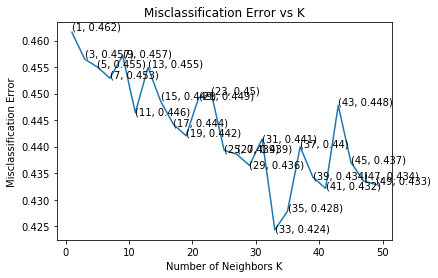

the misclassification error for each k value is :  [0.462 0.457 0.455 0.453 0.457 0.446 0.455 0.449 0.444 0.442 0.449 0.45
 0.439 0.439 0.436 0.441 0.424 0.428 0.44  0.434 0.432 0.448 0.437 0.434
 0.433]


33

In [182]:
optimal_k_avgW2V = k_classifier_brute(X_train, y_train)
optimal_k_avgW2V

Train accuracy 0.6092857142857143
Train Error 0.390714%

The accuracy of the knn classifier for k = 33 is 58.333333%


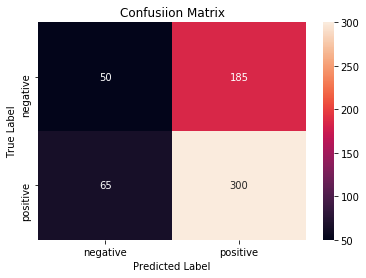

In [183]:
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k_avgW2V)
# fitting the model
knn_optimal.fit(X_train, y_train)
pred = knn_optimal.predict(x_test)

# Accuracy on train data
train_acc_avgW2V = knn_optimal.score(X_train, y_train)
print("Train accuracy", train_acc_avgW2V)

# Error on train data
train_err_avgW2V = 1-train_acc_avgW2V
print("Train Error %f%%" % (train_err_avgW2V))

# evaluate accuracy on test data
acc_avgW2V = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k_avgW2V, acc_avgW2V))

# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### [5.1.4] Applying KNN brute force on TFIDF W2V,<font color='red'> SET 4</font>

In [26]:
# taking the amazon reviwe data set 1200 +ve and 800 -ve.
print(final.Score.value_counts())
Data_POS = final[final["Score"] == 1].sample(n = 1200)
Data_NEG = final[final["Score"] == 0].sample(n = 800)

#sort the data w.r.t time stamp
final_data = pd.concat([Data_POS , Data_NEG])
final_data = final_data.sort_values(by = 'Time')

# taking out text and score and sending it to train, test split
final_Review_Text = final_data['Text']
final_Review_Label = final_data['Score']

from sklearn.model_selection import train_test_split
X_train, x_test, y_train, y_test = train_test_split(final_Review_Text, final_Review_Label, test_size = 0.3, random_state = 42)
print(X_train.shape, y_train.shape, x_test.shape, y_test.shape)


1    4178
0     808
Name: Score, dtype: int64
(1400,) (1400,) (600,) (600,)


In [185]:
len(X_train)

1400

In [33]:
model = TfidfVectorizer(min_df=10, max_features=500, )

tf_idf_matrix = model.fit(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf


#-----------------------------------------------------------------------------------

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(X_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

X_train = tfidf_sent_vectors
len(X_train)

#_---------------------------

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(x_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

x_test = tfidf_sent_vectors
len(x_test)

100%|██████████| 600/600 [35:39<00:00,  3.57s/it]


600

In [39]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
#from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection
#from sklearn import model_selection


The optimal number of neighbors is 5.


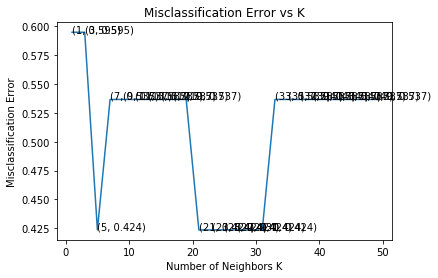

the misclassification error for each k value is :  [0.595 0.595 0.424 0.537 0.537 0.537 0.537 0.537 0.537 0.537 0.424 0.424
 0.424 0.424 0.424 0.424 0.537 0.537 0.537 0.537 0.537 0.537 0.537 0.537
 0.537]


5

In [40]:
optimal_k_bow = k_classifier_brute(X_train, y_train)
optimal_k_bow

Train accuracy 0.595
Train Error 0.405000%

The accuracy of the knn classifier for k = 5 is 61.166667%


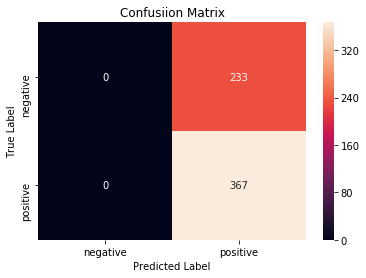

In [41]:

knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k_bow)

# fitting the model
knn_optimal.fit(X_train, y_train)
#knn_optimal.fit(bow_data, y_train)

# predict the response
pred = knn_optimal.predict(x_test)

# Accuracy on train data
train_acc_bow = knn_optimal.score(X_train, y_train)
print("Train accuracy", train_acc_bow)

# Error on train data
train_err_bow = 1-train_acc_bow
print("Train Error %f%%" % (train_err_bow))

# evaluate accuracy on test data
acc_bow = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k_bow, acc_bow))

# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## [5.2] Applying KNN kd-tree

### [5.2.1] Applying KNN kd-tree on BOW,<font color='red'> SET 5</font>

In [42]:
def k_classifier_KD_Tree(X_train, y_train):
    # creating odd list of K for KNN
    myList = list(range(0,50))
    neighbors = list(filter(lambda x: x % 2 != 0, myList))

    # empty list that will hold cv scores
    cv_scores = []

    # perform 10-fold cross validation
    for k in neighbors:
        knn = KNeighborsClassifier(n_neighbors=k, algorithm = "kd_tree")
        scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
        cv_scores.append(scores.mean())

    # changing to misclassification error
    MSE = [1 - x for x in cv_scores]

    # determining best k
    optimal_k = neighbors[MSE.index(min(MSE))]
    print('\nThe optimal number of neighbors is %d.' % optimal_k)

    # plot misclassification error vs k 
    plt.plot(neighbors, MSE)

    for xy in zip(neighbors, np.round(MSE,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
    plt.title("Misclassification Error vs K")
    plt.xlabel('Number of Neighbors K')
    plt.ylabel('Misclassification Error')
    plt.show()

    print("the misclassification error for each k value is : ", np.round(MSE,3))
    return optimal_k


1    4178
0     808
Name: Score, dtype: int64
(1400,) (1400,) (600,) (600,)

The optimal number of neighbors is 3.


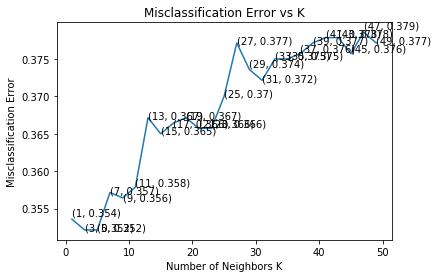

the misclassification error for each k value is :  [0.354 0.352 0.352 0.357 0.356 0.358 0.367 0.365 0.366 0.367 0.366 0.366
 0.37  0.377 0.374 0.372 0.375 0.375 0.376 0.377 0.378 0.378 0.376 0.379
 0.377]
Train accuracy 0.8221428571428572
Train Error 0.177857%

The accuracy of the knn classifier for k = 3 is 65.166667%


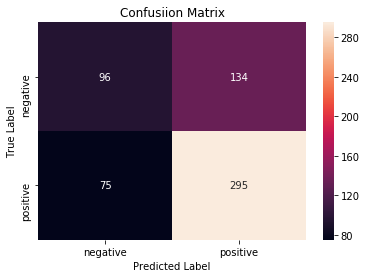

In [43]:

# taking the amazon reviwe data set 1200 +ve and 800 -ve.
print(final.Score.value_counts())
Data_POS = final[final["Score"] == 1].sample(n = 1200)
Data_NEG = final[final["Score"] == 0].sample(n = 800)

#sort the data w.r.t time stamp
final_data = pd.concat([Data_POS , Data_NEG])
final_data = final_data.sort_values(by = 'Time')

# taking out text and score and sending it to train, test split
final_Review_Text = final_data['Text']
final_Review_Label = final_data['Score']

from sklearn.model_selection import train_test_split
X_train, x_test, y_train, y_test = train_test_split(final_Review_Text, final_Review_Label, test_size = 0.3, random_state = 42)
print(X_train.shape, y_train.shape, x_test.shape, y_test.shape)

#converting text to vector
bow = CountVectorizer()
X_train = bow.fit_transform(X_train)
x_test = bow.transform(x_test)

optimal_k_bow = k_classifier_KD_Tree(X_train, y_train)
optimal_k_bow

knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k_bow)

# fitting the model
knn_optimal.fit(X_train, y_train)
#knn_optimal.fit(bow_data, y_train)

# predict the response
pred = knn_optimal.predict(x_test)

# Accuracy on train data
train_acc_bow = knn_optimal.score(X_train, y_train)
print("Train accuracy", train_acc_bow)

# Error on train data
train_err_bow = 1-train_acc_bow
print("Train Error %f%%" % (train_err_bow))

# evaluate accuracy on test data
acc_bow = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k_bow, acc_bow))

# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### [5.2.2] Applying KNN kd-tree on TFIDF,<font color='red'> SET 6</font>

1    4178
0     808
Name: Score, dtype: int64
(1400,) (1400,) (600,) (600,)

The optimal number of neighbors is 37.


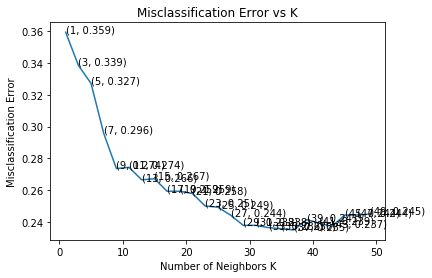

the misclassification error for each k value is :  [0.359 0.339 0.327 0.296 0.274 0.274 0.266 0.267 0.259 0.259 0.258 0.25
 0.249 0.244 0.238 0.238 0.236 0.236 0.235 0.241 0.239 0.237 0.244 0.244
 0.245]
Train accuracy 0.7928571428571428
Train Error 0.207143%

The accuracy of the knn classifier for k = 37 is 76.500000%


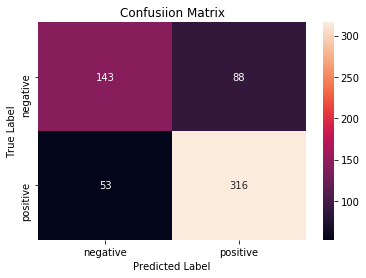

In [44]:
#KNN for TF-IDF

# taking the amazon reviwe data set 1200 +ve and 800 -ve.
print(final.Score.value_counts())
Data_POS = final[final["Score"] == 1].sample(n = 1200)
Data_NEG = final[final["Score"] == 0].sample(n = 800)

#sort the data w.r.t time stamp
final_data = pd.concat([Data_POS , Data_NEG])
final_data = final_data.sort_values(by = 'Time')

# taking out text and score and sending it to train, test split
final_Review_Text = final_data['Text']
final_Review_Label = final_data['Score']

from sklearn.model_selection import train_test_split
X_train, x_test, y_train, y_test = train_test_split(final_Review_Text, final_Review_Label, test_size = 0.3, random_state = 42)
print(X_train.shape, y_train.shape, x_test.shape, y_test.shape)


tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
#tf_idf_vect.fit(X_train)

#print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

X_train = tf_idf_vect.fit_transform(X_train)
#X_train = X_train.toarray()
x_test = tf_idf_vect.transform(x_test)
x_test = x_test.toarray()

optimal_k_tfidf = k_classifier_KD_Tree(X_train, y_train)
optimal_k_tfidf

knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k_tfidf)

# fitting the model
knn_optimal.fit(X_train, y_train)


# predict the response
pred = knn_optimal.predict(x_test)

# Accuracy on train data
train_acc_tfidf = knn_optimal.score(X_train, y_train)
print("Train accuracy", train_acc_tfidf)

# Error on train data
train_err_tfidf = 1-train_acc_tfidf
print("Train Error %f%%" % (train_err_tfidf))

# evaluate accuracy on test data
acc_tfidf = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k_tfidf, acc_tfidf))

# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### [5.2.3] Applying KNN kd-tree on AVG W2V,<font color='red'> SET 3</font>

1    4178
0     808
Name: Score, dtype: int64
(1400,) (1400,) (600,) (600,)
[('and', 0.9997566938400269), ('too', 0.9997363686561584), ('also', 0.999732255935669), ('little', 0.9997276663780212), ('which', 0.9997180104255676), ('almost', 0.9997153282165527), ('regular', 0.9997104406356812), ('actually', 0.9997013807296753), ('bad', 0.9996998310089111), ('flavor.', 0.9996994733810425)]
[('inside', 0.996915340423584), ('variety', 0.9967179894447327), ('Only', 0.9967055320739746), ('out.', 0.9967048764228821), ('BBQ', 0.9966320991516113), ('chocolate.', 0.9966258406639099), ('part', 0.9965997338294983), ('dented', 0.9965977668762207), ('seems', 0.9965957403182983), ('delicious.', 0.9965822696685791)]
number of words that occured minimum 5 times  2249
sample words  ['I', 'am', 'so', 'happy', 'that', 'Bisquick', 'came', 'out', 'with', 'a', 'gluten', 'free', "We've", 'tried', 'many', 'other', 'brands', 'of', 'pancake', 'and', 'waffle', 'mix,', 'hands', 'down,', 'is', 'the', 'We', 'just', 'ma

100%|█████████████████████████████████████████████████████████████████████████████| 1400/1400 [00:01<00:00, 837.85it/s]


1400
50
number of words that occured minimum 5 times  1172
sample words  ["I'm", 'a', 'with', 'and', 'I', 'found', 'this', 'was', 'using', 'various', 'other', 'body', 'my', 'always', 'felt', 'like', 'could', 'never', 'get', 'enough', 'that', 'the', 'seemed', 'difficult', 'to', 'quickly', 'spread', 'all', 'Since', 'started', 'stuff', '(for', 'few', 'years', "haven't", 'looked', 'back.', 'This', 'is', 'nice', 'can', 'decent', 'amount', 'of', 'somewhat', 'on', 'It', 'goes', 'smooth', 'up']


100%|██████████████████████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 1160.36it/s]


600
50

The optimal number of neighbors is 21.


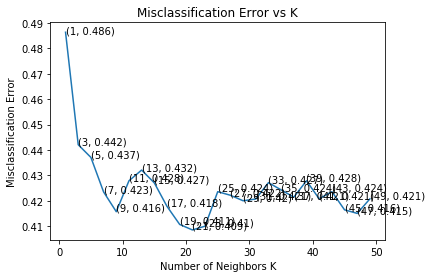

the misclassification error for each k value is :  [0.486 0.442 0.437 0.423 0.416 0.428 0.432 0.427 0.418 0.411 0.409 0.41
 0.424 0.422 0.42  0.421 0.427 0.424 0.421 0.428 0.421 0.424 0.416 0.415
 0.421]
Train accuracy 0.65
Train Error 0.350000%

The accuracy of the knn classifier for k = 21 is 53.000000%


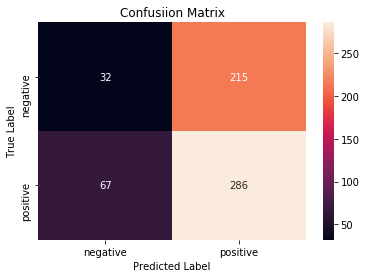

In [200]:
# taking the amazon reviwe data set 1200 +ve and 800 -ve.
print(final.Score.value_counts())
Data_POS = final[final["Score"] == 1].sample(n = 1200)
Data_NEG = final[final["Score"] == 0].sample(n = 800)

#sort the data w.r.t time stamp
final_data = pd.concat([Data_POS , Data_NEG])
final_data = final_data.sort_values(by = 'Time')

# taking out text and score and sending it to train, test split
final_Review_Text = final_data['Text']
final_Review_Label = final_data['Score']

from sklearn.model_selection import train_test_split
X_train, x_test, y_train, y_test = train_test_split(final_Review_Text, final_Review_Label, test_size = 0.3, random_state = 42)
print(X_train.shape, y_train.shape, x_test.shape, y_test.shape)

i=0
list_of_sentance=[]
for sentance in X_train:
    list_of_sentance.append(sentance.split())

    
w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
print(w2v_model.wv.most_similar('great'))
print('='*50)
print(w2v_model.wv.most_similar('worst'))

w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

X_train = sent_vectors

i=0
list_of_sentance=[]
for sentance in x_test:
    list_of_sentance.append(sentance.split())

w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)

w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

x_test = sent_vectors

optimal_k_avgW2V = k_classifier_KD_Tree(X_train, y_train)
optimal_k_avgW2V

knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k_avgW2V)
# fitting the model
knn_optimal.fit(X_train, y_train)
pred = knn_optimal.predict(x_test)

# Accuracy on train data
train_acc_avgW2V = knn_optimal.score(X_train, y_train)
print("Train accuracy", train_acc_avgW2V)

# Error on train data
train_err_avgW2V = 1-train_acc_avgW2V
print("Train Error %f%%" % (train_err_avgW2V))

# evaluate accuracy on test data
acc_avgW2V = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k_avgW2V, acc_avgW2V))

# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### [5.2.4] Applying KNN kd-tree on TFIDF W2V,<font color='red'> SET 4</font>

1    4178
0     808
Name: Score, dtype: int64
(1400,) (1400,) (600,) (600,)


100%|██████████| 600/600 [00:10<00:00, 57.18it/s]



The optimal number of neighbors is 1.


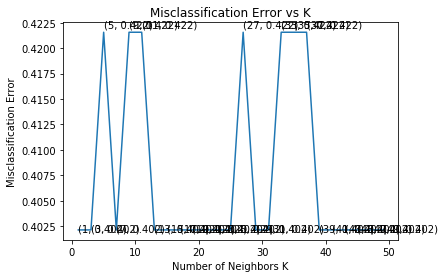

the misclassification error for each k value is :  [0.402 0.402 0.422 0.402 0.422 0.422 0.402 0.402 0.402 0.402 0.402 0.402
 0.402 0.422 0.402 0.402 0.422 0.422 0.422 0.402 0.402 0.402 0.402 0.402
 0.402]
Train accuracy 0.5978571428571429
Train Error 0.402143%

The accuracy of the knn classifier for k = 1 is 60.500000%


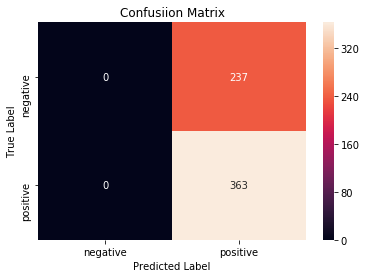

In [45]:
# taking the amazon reviwe data set 1200 +ve and 800 -ve.
print(final.Score.value_counts())
Data_POS = final[final["Score"] == 1].sample(n = 1200)
Data_NEG = final[final["Score"] == 0].sample(n = 800)

#sort the data w.r.t time stamp
final_data = pd.concat([Data_POS , Data_NEG])
final_data = final_data.sort_values(by = 'Time')

# taking out text and score and sending it to train, test split
final_Review_Text = final_data['Text']
final_Review_Label = final_data['Score']

from sklearn.model_selection import train_test_split
X_train, x_test, y_train, y_test = train_test_split(final_Review_Text, final_Review_Label, test_size = 0.3, random_state = 42)
print(X_train.shape, y_train.shape, x_test.shape, y_test.shape)



model = TfidfVectorizer(min_df=10, max_features=500, )

tf_idf_matrix = model.fit(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf


#-----------------------------------------------------------------------------------

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(X_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

X_train = tfidf_sent_vectors
len(X_train)

#_---------------------------

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(x_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

x_test = tfidf_sent_vectors
len(x_test)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
#from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection
#from sklearn import model_selection

optimal_k_bow = k_classifier_KD_Tree(X_train, y_train)
optimal_k_bow


knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k_bow)

# fitting the model
knn_optimal.fit(X_train, y_train)
#knn_optimal.fit(bow_data, y_train)

# predict the response
pred = knn_optimal.predict(x_test)

# Accuracy on train data
train_acc_bow = knn_optimal.score(X_train, y_train)
print("Train accuracy", train_acc_bow)

# Error on train data
train_err_bow = 1-train_acc_bow
print("Train Error %f%%" % (train_err_bow))

# evaluate accuracy on test data
acc_bow = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k_bow, acc_bow))

# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# [6] Conclusions

In [58]:
from prettytable import PrettyTable

tbl = PrettyTable()

tbl.field_names = ["V type", "KNN TA", "KNN TE", "KNN TeA", "KNN TeE", "KD TA", "KD TE", "KD TeA","KD TeE"]
tbl.add_row(["Bow","80%","20%","61.50%","39.50%","82.22%","17.78%","65.16%","35.84%"])
tbl.add_row(["TF-IDF","76.92%","23.07%","74.00%","26.00%","79.28%","20.71%","76.50%","23.50%"])
tbl.add_row(["Avg-W2V","60.92%","39.07%","58.33%","41.67%","65.00%","35.00%","53.00%","47.00%"])
tbl.add_row(["TFIDF-W2V","59.50%","40.50%","61.16%","38.84%","59.78%","40.21%","60.50%","39.50%"])

print(tbl)

print("TA:  Train Accuracy")
print("TE:  Train Error")
print("TeA: Test Accuracy")
print("TeE: Test Accuracy")


+-----------+--------+--------+---------+---------+--------+--------+--------+--------+
|   V type  | KNN TA | KNN TE | KNN TeA | KNN TeE | KD TA  | KD TE  | KD TeA | KD TeE |
+-----------+--------+--------+---------+---------+--------+--------+--------+--------+
|    Bow    |  80%   |  20%   |  61.50% |  39.50% | 82.22% | 17.78% | 65.16% | 35.84% |
|   TF-IDF  | 76.92% | 23.07% |  74.00% |  26.00% | 79.28% | 20.71% | 76.50% | 23.50% |
|  Avg-W2V  | 60.92% | 39.07% |  58.33% |  41.67% | 65.00% | 35.00% | 53.00% | 47.00% |
| TFIDF-W2V | 59.50% | 40.50% |  61.16% |  38.84% | 59.78% | 40.21% | 60.50% | 39.50% |
+-----------+--------+--------+---------+---------+--------+--------+--------+--------+
TA:  Train Accuracy
TE:  Train Error
TeA: Test Accuracy
TeE: Test Accuracy


* BoW: for both Brute Force and KD Tree error increased with increase in k, optimal K is found out to be 3
* TF-IFD unlike BoW, here error decreases with increase in k optimal k for Brute Force is 49 and for KD Tree is 37
* Avg W2V: in this case both test and train error tend to stabiles after 20~30 Optimal k for Brute Force 33 and KD tree 21
* Apart from the above case TF-IDF has fluctuating error where error increases >5 and <20 and increases after k >30
* It if found out to be BoW with kd tree has the maximum accuracy